<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/colab_g_recommender_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sections as Input

In [1]:
pip install wandb

In [2]:
!wandb login

wandb: Currently logged in as: doris (use `wandb login --relogin` to force relogin)


In [3]:
import wandb

In [4]:
!pip uninstall gensim -y

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2


In [5]:
!pip install gensim

  Using cached gensim-4.1.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)


In [6]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 
from gensim.models.doc2vec import Doc2Vec
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim import similarities
import pickle
import os

In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
print(gensim.__version__)

4.1.2


In [9]:
!rm data.csv

# Configuration


In [10]:
use_wandb = False

In [11]:
chords_repeated = 'rep' 
chords_preprocessing = 'rootAndDegreesPlus'

In [12]:
ngrams_for_input = [1]

In [13]:
input_files = {
    'sections': {
        'rep': {
            # M7 and 6 reduced to major triad, m7 reduced to m, dominant 7, m7b5, diminished, and all (b5) left as they are.
            'rootAndDegreesPlus': '1BDYukaIj72jmi9PqZVrCAqKbyxg8Z4yq',
            'rootAndDegrees7': '',
            'rootAndDegreesSimplified': ''
        },
    },
    'tunes': {
        'rep': {
            'rootAndDegreesPlus': '',
            'rootAndDegrees7': '',
            'rootAndDegreesSimplified': '',
        },
        'norep': {
            'rootAndDegreesPlus': '',
            'rootAndDegrees7': '',
            'rootAndDegreesSimplified': '',
        }
    }
}

In [14]:
tunes_eval_list = [
  "Sweet Sue, Just You [jazz1350]",
  "These Foolish Things [jazz1350]", 
  "Blue Moon [jazz1350]",
  "All Of Me [jazz1350]",
  "All God's Chillun Got Rhythm [jazz1350]",
  "I Got Rhythm [jazz1350]",
  "Bye Bye Blackbird [jazz1350]",
  "Old Fashioned Love [trad]",
  "Dinah [jazz1350]",
  "Honeysuckle Rose [jazz1350]",
  "Misty [jazz1350]",
  "We'll Be Together Again [jazz1350]",
  "East Of The Sun [jazz1350]",
  "Sophisticated Lady [jazz1350]",
  "Perdido [jazz1350]",
  "Naima [jazz1350]",
  "Call Me Irresponsible [jazz1350]",
  "Corcovado [jazz1350]",
  "Footprints [jazz1350]",
  "Giant Steps [jazz1350]",
  "But Beautiful [jazz1350]",
  "Rockin' Chair [jazz1350]",
  "Blood Count [jazz1350]",
  "After You've Gone [jazz1350]",
]

tunes_eval_list = sorted(tunes_eval_list)
tunes_eval_list

["After You've Gone [jazz1350]",
 "All God's Chillun Got Rhythm [jazz1350]",
 'All Of Me [jazz1350]',
 'Blood Count [jazz1350]',
 'Blue Moon [jazz1350]',
 'But Beautiful [jazz1350]',
 'Bye Bye Blackbird [jazz1350]',
 'Call Me Irresponsible [jazz1350]',
 'Corcovado [jazz1350]',
 'Dinah [jazz1350]',
 'East Of The Sun [jazz1350]',
 'Footprints [jazz1350]',
 'Giant Steps [jazz1350]',
 'Honeysuckle Rose [jazz1350]',
 'I Got Rhythm [jazz1350]',
 'Misty [jazz1350]',
 'Naima [jazz1350]',
 'Old Fashioned Love [trad]',
 'Perdido [jazz1350]',
 "Rockin' Chair [jazz1350]",
 'Sophisticated Lady [jazz1350]',
 'Sweet Sue, Just You [jazz1350]',
 'These Foolish Things [jazz1350]',
 "We'll Be Together Again [jazz1350]"]

In [15]:
contrafacts_1350jazz = {
               "26-2": "Confirmation",
               "52nd Street Theme": "I Got Rhythm",
               "Ablution": "All The Things You Are",
               "Anthropology": "I Got Rhythm",
               "Ballade": "As Long As I Live",
               "Bright Mississippi": "Sweet Georgia Brown",
               "C.T.A.": "I Got Rhythm",
               # "Celia": "I Got Rhythm",
               "Cottontail": "I Got Rhythm",
               "Countdown": "Tune Up",
               "Dewey Square": "Oh, Lady Be Good",
               "Dexterity": "I Got Rhythm",
               "Dig": "Sweet Georgia Brown",
               "Donna Lee": "Indiana (Back Home Again In)",
               "Don't Be That Way": "I Got Rhythm",
               #"Eternal Triangle": "I Got Rhythm",
               "Evidence": "Just You, Just Me",
               "Flintstones": "I Got Rhythm",
               "Four On Six": "Summertime",
               "Freight Train": "Blues For Alice",
               "Good Bait": "I Got Rhythm",
               "Hackensack": "Oh, Lady Be Good",
               "Half Nelson": "Lady Bird",
               "Hot House": "What Is This Thing Called Love",
               "Impressions": "So What",
               "In A Mellow Tone (In A Mellotone)": "Rose Room",
               "In Walked Bud": "Blue Skies",
               "Ko Ko": "Cherokee",
               "Lennie's Pennies": "Pennies From Heaven",   ## Lennie's Pennies is in minor and therefore transposed to Amin... not possible to recognize like that
               # "Let's Call This": "Honeysuckle Rose",
               "Little Rootie Tootie": "I Got Rhythm",
               "Little Willie Leaps": "All God's Chillun Got Rhythm",
               "Lullaby Of Birdland": "Love Me Or Leave Me",
               #"Moose The Mooche": "I Got Rhythm",
               "My Little Suede Shoes": "Jeepers Creepers",
               #"Oleo": "I Got Rhythm",
               "Ornithology": "How High The Moon",
               #"Passport": "I Got Rhythm",
               "Quasimodo (Theme)": "Embraceable You",
               #"Rhythm-a-ning": "I Got Rhythm",
               "Room 608": "I Got Rhythm",
               #"Salt Peanuts": "I Got Rhythm",
               "Satellite": "How High The Moon",
               "Scrapple From The Apple": "Honeysuckle Rose", # A section
               "Scrapple From The Apple": "I Got Rhythm", # B section
               #"Segment": "I Got Rhythm",
               #"Seven Come Eleven": "I Got Rhythm",
               #"Shaw 'Nuff": "I Got Rhythm",
               #"Theme, The": "I Got Rhythm",
               "Tour De Force": "Jeepers Creepers",
               "Wow": "You Can Depend On Me",
               "Yardbird Suite": "Rosetta",

               # following tunes are not from wikipedia:
               "Sweet Sue, Just You": "Honeysuckle Rose",  # A section
               # "All Of Me": "Pennies From Heaven", # bars 25-28 of All of Me are same as bars 17-20 of Pennies From Heaven, but different key!
               "Sweet Sue, Just You": "Bye Bye Blackbird", # Bridge same
               "These Foolish Things": "Blue Moon", # first 8 bars same
               "These Foolish Things": "More Than You Know",
               "These Foolish Things": "Isn't It A Pity",
               "These Foolish Things": "Soultrain",
               "These Foolish Things": "Why Do I Love You",
               "Misty": "Portrait Of Jennie",
               "Misty": "September In The Rain",
               "Misty": "I May Be Wrong",                    
}


contrafacts = {}
for key, value in contrafacts_1350jazz.items():
  contrafacts[f"{key} [jazz1350]"] = f"{value} [jazz1350]"

contrafacts


{'26-2 [jazz1350]': 'Confirmation [jazz1350]',
 '52nd Street Theme [jazz1350]': 'I Got Rhythm [jazz1350]',
 'Ablution [jazz1350]': 'All The Things You Are [jazz1350]',
 'Anthropology [jazz1350]': 'I Got Rhythm [jazz1350]',
 'Ballade [jazz1350]': 'As Long As I Live [jazz1350]',
 'Bright Mississippi [jazz1350]': 'Sweet Georgia Brown [jazz1350]',
 'C.T.A. [jazz1350]': 'I Got Rhythm [jazz1350]',
 'Cottontail [jazz1350]': 'I Got Rhythm [jazz1350]',
 'Countdown [jazz1350]': 'Tune Up [jazz1350]',
 'Dewey Square [jazz1350]': 'Oh, Lady Be Good [jazz1350]',
 'Dexterity [jazz1350]': 'I Got Rhythm [jazz1350]',
 'Dig [jazz1350]': 'Sweet Georgia Brown [jazz1350]',
 "Don't Be That Way [jazz1350]": 'I Got Rhythm [jazz1350]',
 'Donna Lee [jazz1350]': 'Indiana (Back Home Again In) [jazz1350]',
 'Evidence [jazz1350]': 'Just You, Just Me [jazz1350]',
 'Flintstones [jazz1350]': 'I Got Rhythm [jazz1350]',
 'Four On Six [jazz1350]': 'Summertime [jazz1350]',
 'Freight Train [jazz1350]': 'Blues For Alice [jazz

# Initialization

## Download the Data

In [16]:
input_data = input_files['sections'][chords_repeated][chords_preprocessing]

input_path = f"https://docs.google.com/uc?export=download&id={input_data}"
data_file_name = 'data.csv'


In [17]:
input_path

'https://docs.google.com/uc?export=download&id=1BDYukaIj72jmi9PqZVrCAqKbyxg8Z4yq'

In [18]:
!wget --no-check-certificate "$input_path" -O "$data_file_name"

--2021-11-26 20:15:16--  https://docs.google.com/uc?export=download&id=1BDYukaIj72jmi9PqZVrCAqKbyxg8Z4yq
Resolving docs.google.com (docs.google.com)... 172.253.119.100, 172.253.119.138, 172.253.119.101, ...
Connecting to docs.google.com (docs.google.com)|172.253.119.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qkptbmb71llu0v119r4lr3kj9nemcspe/1637957700000/14329102864480165501/*/1BDYukaIj72jmi9PqZVrCAqKbyxg8Z4yq?e=download [following]
--2021-11-26 20:15:16--  https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qkptbmb71llu0v119r4lr3kj9nemcspe/1637957700000/14329102864480165501/*/1BDYukaIj72jmi9PqZVrCAqKbyxg8Z4yq?e=download
Resolving doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-docs.googleusercontent.com)... 172.217.219.132, 2607:f8b0:4001:c13::84
Connecting to doc-0k-4c-docs.googleusercontent.com (doc-0k

### Read Chords Input Data

In [19]:
df = pd.read_csv(data_file_name, sep='\t', index_col="id")
df = df.reset_index()
df.head(5)

,id,file_name,title,title_playlist,tune_mode,tune_id,section_name,section_id,chords
0,0,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,A,1,C Eb7 G# B7 E G7 Gm C7 F G#7 C# E7 Am D7 Dm G7
1,1,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,A,2,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
2,2,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,B,3,Gm C7 Bm E7 A C7 F Bbm Eb7 G# Dm G7
3,3,dataset/jazz1350/26-2.xml,26-2,26-2 [jazz1350],major,0,A,4,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
4,4,dataset/jazz1350/500 Miles High.xml,500 Miles High,500 Miles High [jazz1350],minor,1,NaN,0,Am Am Cm Cm Eb Eb Em7b5 A7 Dm Dm Bm7b5 Bm7b5 B...


### Meta Data

In [20]:
titles = df.loc[:, ['id', 'tune_id', 'section_id', 'section_name', 'title', 'title_playlist', 'tune_mode']]
titles[:5]

,id,tune_id,section_id,section_name,title,title_playlist,tune_mode
0,0,0,1,A,26-2,26-2 [jazz1350],major
1,1,0,2,A,26-2,26-2 [jazz1350],major
2,2,0,3,B,26-2,26-2 [jazz1350],major
3,3,0,4,A,26-2,26-2 [jazz1350],major
4,4,1,0,NaN,500 Miles High,500 Miles High [jazz1350],minor


In [21]:
titles_dict = titles.to_dict()

sectionid_to_title = titles_dict['title_playlist']
sectionid_to_titleid = titles_dict['tune_id']


In [22]:
tunes = df.loc[:, ['tune_id', 'title_playlist']].drop_duplicates()
tunes = tunes.set_index('tune_id').to_dict()
titleid_to_title = tunes['title_playlist']

In [23]:
title_to_titleid = {v: k for k, v in titleid_to_title.items()}


In [24]:
titles_rows = titles.to_dict(orient='records')
sectionid_to_section = []
for i, row in enumerate(titles_rows):
  name = f"{row['title']}, section{row['section_id']} ({row['section_name']})"
  sectionid_to_section.append(name)
  

In [25]:
title_to_sectionid = {}

for row in titles.iterrows():
  title = row[1]['title_playlist']
  if title not in title_to_sectionid:
    title_to_sectionid[title] = [row[1]['id']]
  else:
    title_to_sectionid[title].append(row[1]['id'])

### Create Directories on Colab

In [26]:
!rm -R output
!mkdir output

### Test Data

In [27]:
tunes_eval_list = sorted(tunes_eval_list)

In [28]:
#contrafacts_test = []
#for reference, compare in contrafacts.items():
#  contrafacts_test.append([title_to_sectionid[reference], title_to_sectionid[compare]])

## Initialization for wandb variables

In [29]:
recommender_results_cols = ['reference', 'id', 'method', 'similar', 'score_div_max', 'score']
recommender_results = pd.DataFrame(columns=recommender_results_cols)

In [30]:
lsi_config = {
    'num_topics': 200,
}

In [31]:
doc2vec_config = {
    'general': {
        'chords_preprocessing': chords_preprocessing,
        'chords_repeated': chords_repeated,
        'document_tags': 'SectionsTunes',
    },
    'model': {
        'dm': 1,
        'vector_size': 100,
        'window': 4,
        'epochs': 40,
        #'workers': 1,
        'min_count': 1,
        'negative': 10,
        'sample': 0.001,
        'seed': 42
    }
}

In [32]:
if use_wandb:
  wandb.init(
        # Set entity to specify your username or team name
        # ex: entity="carey",
        # Set the project where this run will be logged
        project="jazztunes", 
        
        # Track hyperparameters and run metadata
        config={
            "input_data": input_path,
            "ngrams_input": ngrams_for_input,
            "comparison": "sections",
            "lsi": lsi_config,
            "doc2vec": doc2vec_config
        }
    )

In [33]:
if use_wandb:
  artifact = wandb.Artifact('input_data', type='dataset')
  artifact.add_file('data.csv')
  wandb.log_artifact(artifact)

## Helpers functions

In [34]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [35]:
def raw_chords_to_df(tunes):
  tunes_chords = [item for tune in tunes for item in tune]
  counts = Counter(tunes_chords)
  df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return df

# Data Preparation

In [36]:
lines = df.loc[:, 'chords'].tolist()
data = [line.split(' ') for line in lines]

In [37]:
processed_corpus = []
for line in data:
  tune_n = []
  for n in ngrams_for_input:
    tune_n.extend(ngrams(line, n=n))
  processed_corpus.append(tune_n)

for line in processed_corpus[:5]:
  print(line)

['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'G#7', 'C#', 'E7', 'Am', 'D7', 'Dm', 'G7']
['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'Eb7', 'G#', 'B7', 'E', 'G7', 'C']
['Gm', 'C7', 'Bm', 'E7', 'A', 'C7', 'F', 'Bbm', 'Eb7', 'G#', 'Dm', 'G7']
['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'Eb7', 'G#', 'B7', 'E', 'G7', 'C']
['Am', 'Am', 'Cm', 'Cm', 'Eb', 'Eb', 'Em7b5', 'A7', 'Dm', 'Dm', 'Bm7b5', 'Bm7b5', 'Bbm', 'Bbm', 'Fm', 'Fm', 'E7', 'E7', 'Fm', 'Fm', 'C#', 'C#', 'Fm', 'Fm', 'C#', 'C#']


#### Corpus Overview

In [38]:
tokens = [item for l in processed_corpus for item in l]
total_tokens = len(tokens)
vocab_size = len(set(tokens))
vocab_prop = 100*vocab_size/total_tokens

print(f"Total Number of tokens: {total_tokens}")
print(f"Size of vocabulary: {vocab_size}")
print(f"Proportion of vocabulary in corpus: {vocab_prop:.02f}%")

Total Number of tokens: 82622
Size of vocabulary: 72
Proportion of vocabulary in corpus: 0.09%


In [39]:
df_chords = raw_chords_to_df(processed_corpus)
df_chords

,chord,count
0,C,14387
5,G7,11144
14,Dm,7991
12,Am,5724
21,A7,4467
...,...,...
62,Ddim,13
70,G#7(+b5),12
65,F7(+b5),9
69,Cm7b5,9


In [40]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
df_chords_top = df_chords.query('count > 100')

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

2021-11-26 20:15:18,567 : INFO : NumExpr defaulting to 2 threads.


Plot Distribution accoring to Zipf's Law

source: https://stats.stackexchange.com/questions/331219/characterizing-fitting-word-count-data-into-zipf-power-law-lognormal

In [41]:
from collections import Counter

counter_of_words = df_chords.set_index('chord').to_dict(orient='dict')
counter_of_words = Counter(counter_of_words['count'])
counter_of_counts = Counter(counter_of_words.values())

word_counts = np.array(list(counter_of_counts.keys()))
freq_of_word_counts = np.array(list(counter_of_counts.values()))

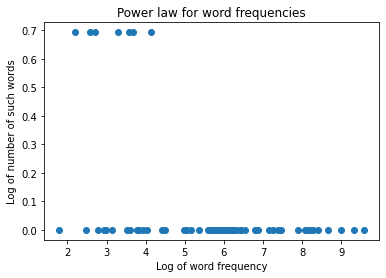

In [42]:
plt.scatter(np.log(word_counts), np.log(freq_of_word_counts))
plt.xlabel('Log of word frequency')
plt.ylabel('Log of number of such words')
plt.title('Power law for word frequencies')

plt.savefig('plot.png')

In [43]:
def neg_zipf_likelihood(s):
    n = sum(freq_of_word_counts)
    # for each word count, find the probability that a random word has such word count
    probas = word_counts ** (-s) / np.sum(np.arange(1, n+1) **(-s))
    log_likelihood = sum(np.log(probas) * word_counts)
    return -log_likelihood

from scipy.optimize import minimize_scalar
s_best = minimize_scalar(neg_zipf_likelihood, [0.1, 3.0] )
print(s_best.x)

-399.3962569709492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

overflow encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1987: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

divide by zero encountered in log



In [44]:
if use_wandb:
  wandb.log(
      {"corpus": {
              "total_tokens": total_tokens,
              "vocab_size": vocab_size,
              "vocab_proportion_in_corpus": vocab_prop,
              "zipf_plot": wandb.Image('plot.png'),
              }
      }
  )

# TF-IDF

In [45]:
dictionary = corpora.Dictionary(processed_corpus)
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
tfidf = TfidfModel(bow_corpus)

2021-11-26 20:15:20,086 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-26 20:15:20,244 : INFO : built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5391 documents (total 82622 corpus positions)
2021-11-26 20:15:20,248 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5391 documents (total 82622 corpus positions)", 'datetime': '2021-11-26T20:15:20.248185', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-26 20:15:20,312 : INFO : collecting document frequencies
2021-11-26 20:15:20,314 : INFO : PROGRESS: processing document #0
2021-11-26 20:15:20,332 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 5391 documents and 72 features (41238 matrix non-zeros)', 'datetime': '2021-11-26T20:15:20.332614', 'gensim': '4.1.2', 'python': '3.

In [46]:
# dictionary.token2id

In [47]:
!rm -R index
!mkdir index

In [48]:
# Note: SparseMatrixSimilarity crashes due to lacking memory
#from gensim.test.utils import get_tmpfile
#index_tmpfile = get_tmpfile("index")
#index_tfidf = similarities.Similarity('/content/index/index_tfidf', bow_corpus, num_features=len(dictionary))

index_tfidf = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features = len(dictionary))

2021-11-26 20:15:20,655 : INFO : creating sparse index
2021-11-26 20:15:20,657 : INFO : creating sparse matrix from corpus
2021-11-26 20:15:20,663 : INFO : PROGRESS: at document #0
2021-11-26 20:15:21,058 : INFO : created <5391x72 sparse matrix of type '<class 'numpy.float32'>'
	with 41238 stored elements in Compressed Sparse Row format>


In [49]:
tfidf.save('/content/index/tfidf.model')  # save model
index_tfidf.save('/content/index/tfidf.index') #save index

2021-11-26 20:15:21,082 : INFO : TfidfModel lifecycle event {'fname_or_handle': '/content/index/tfidf.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-26T20:15:21.082608', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-26 20:15:21,088 : INFO : saved /content/index/tfidf.model
2021-11-26 20:15:21,091 : INFO : SparseMatrixSimilarity lifecycle event {'fname_or_handle': '/content/index/tfidf.index', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-26T20:15:21.091084', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-26 20:15:21,095 : INFO : saved /content/index/tfidf.index


## Tests

In [50]:
def get_sim_scores(tunes, index, model):

    df_sim = pd.DataFrame(columns=['reference_title',
                                   'reference_titleid',
                                   'similar_title',
                                   'ref_section', 
                                   'similar_section', 
                                   'score', 
                                  ])

    for tune in tunes:
      print()
      print("-"*50)
      for s1 in title_to_sectionid[tune]:
      
          query = processed_corpus[s1]
          query_bow = dictionary.doc2bow(query)

          # perform a similarity query against the corpus
          similarities = index[model[query_bow]]
          sims = sorted(enumerate(similarities), key=lambda item: -item[1])
          
          print(s1, sectionid_to_section[s1])
          n = 0
          for s2, s2_score in sims:
            
            # store the top N best results
            if n > 40:
                break
            # don't count self-similarity between sections of the same tune
            if s2 not in title_to_sectionid[tune]:
                n += 1
            
                # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

                df_sim.loc[len(df_sim)] = [tune,
                                           title_to_titleid[tune],
                                           sectionid_to_title[s2],
                                           sectionid_to_section[s1], 
                                           sectionid_to_section[s2], 
                                           s2_score, 
                                           ]
    return df_sim

In [51]:
def recommend_tune(df, tune_name):

  df_tune = df.query(f'reference_title == "{tune_name}"')
  ff = df_tune.iloc[:]

  # get the maximum similarity score for each section and store in new column
  ff['max'] = ff.groupby('ref_section')['score'].transform('max')

  # scale the score with the maxmum value of each section
  ff['score_div_max'] = ff['score'] / ff['max']

  # consider only the top N tunes for each group
  ff = ff.sort_values(['ref_section', 'score_div_max'], ascending=[True, False])
  result = ff.groupby('ref_section').head(30)
  
  # if multiple rows from the same similar tune, keep only the similar_title with the highest score_div_max
  ### TODO not needed anymore
  result = result.groupby('similar_title').max('score_div_max').sort_values('score_div_max', ascending=False)

  # add the name of the reference tune
  result['reference'] = tune_name
  result['reference_titleid'] = title_to_titleid[tune_name]
  result = result.reset_index()
  result = result.loc[:, ['reference', 'reference_titleid', 'similar_title', 'score', 'max', 'score_div_max']]
  result = result.reset_index()
  return result, ff

### Single Tunes

In [52]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index_tfidf, tfidf)

# save a copy of the results; all results will be concatenated at the end
df_tfidf = df_sim[:]


--------------------------------------------------
125 After You've Gone, section1 (A)
126 After You've Gone, section2 (B)
127 After You've Gone, section3 (A)
128 After You've Gone, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
474 Blood Count, section1 (A)
475 Blood Count, section2 (A)
476 Blood Count, section3 (B)
477 Blood Count, section4 (A)
478 Blood Count, section5 (C)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

---------------------------------

In [53]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50, title='Scores for TF-IDF')
fig.show()

In [54]:
if use_wandb:
  wandb.log({"scores_hist": fig})

In [55]:
result, details = recommend_tune(df_sim, "These Foolish Things [jazz1350]")
result.head(5)

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


,index,reference,reference_titleid,similar_title,score,max,score_div_max
0,0,These Foolish Things [jazz1350],1168,I Loves You Porgy [jazz1350],0.986726,0.986726,1.000000
1,1,These Foolish Things [jazz1350],1168,More Than You Know [jazz1350],0.796439,0.796439,1.000000
2,2,These Foolish Things [jazz1350],1168,What Are You Doing New Years [jazz1350],0.762513,0.796439,0.957402
3,3,These Foolish Things [jazz1350],1168,They Can't Take That Away From Me [jazz1350],0.748027,0.796439,0.939214
4,4,These Foolish Things [jazz1350],1168,If I Had You [jazz1350],0.744246,0.796439,0.934467


Copy results into a dataframe for later logging to W&B

In [56]:
dd = pd.DataFrame(columns = recommender_results_cols)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)
  dd['id'] = result['index']
  dd['method'] = 'tfidf'
  dd['reference'] = tune
  dd['similar'] = result['similar_title']
  dd['score_div_max'] = result['score_div_max']
  dd['score'] = result['score']

recommender_results = recommender_results.append(dd)

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score',

### Test Contrafacts

With the model, query the top N highest matches for each section. For a tune, if at least one section receives the recommendation  for the expected title, increase the match counter.

In [57]:
def test_contrafacts(tunes, index, model, N=15):
  matches = 0
  number_of_sections = 0
  results = {}

  for tune, similar_tune in tunes.items():
    
    # loop over all sections of the tune
    section_matches = 0
    for s1 in title_to_sectionid[tune]:
      query = processed_corpus[s1]
      query_bow = dictionary.doc2bow(query)

      # perform a similarity query against the corpus
      similarities = index[model[query_bow]]
      sims = sorted(enumerate(similarities), key=lambda item: -item[1])

      # check if the section matches the expected title; consider only the first 15 recommendations
      i = 0
      for sectionid, value in sims:
        if i >= N:
          break
        i += 1
        if sectionid_to_title[sectionid] == similar_tune:
          section_matches += 1

    # for each title, increase matches if at least one of the section matched the expected title
    if section_matches > 0:
      matches += 1  
      results[tune] = 1
    else:
      results[tune] = 0
  
  return matches, results


In [58]:
topN = 15
matches, results = test_contrafacts(contrafacts, index_tfidf, tfidf, topN)

[print(f"{val}: {rr}") for rr, val in results.items()] 
print() 
print(f"Found matches: {matches} out of {len(contrafacts)}: {100*matches/len(contrafacts):.3f}%")

0: 26-2 [jazz1350]
0: 52nd Street Theme [jazz1350]
1: Ablution [jazz1350]
1: Anthropology [jazz1350]
0: Ballade [jazz1350]
1: Bright Mississippi [jazz1350]
1: C.T.A. [jazz1350]
1: Cottontail [jazz1350]
1: Countdown [jazz1350]
0: Dewey Square [jazz1350]
1: Dexterity [jazz1350]
1: Dig [jazz1350]
1: Donna Lee [jazz1350]
0: Don't Be That Way [jazz1350]
1: Evidence [jazz1350]
1: Flintstones [jazz1350]
0: Four On Six [jazz1350]
1: Freight Train [jazz1350]
0: Good Bait [jazz1350]
1: Hackensack [jazz1350]
1: Half Nelson [jazz1350]
1: Hot House [jazz1350]
1: Impressions [jazz1350]
0: In A Mellow Tone (In A Mellotone) [jazz1350]
1: In Walked Bud [jazz1350]
1: Ko Ko [jazz1350]
0: Lennie's Pennies [jazz1350]
0: Little Rootie Tootie [jazz1350]
0: Little Willie Leaps [jazz1350]
0: Lullaby Of Birdland [jazz1350]
0: My Little Suede Shoes [jazz1350]
1: Ornithology [jazz1350]
0: Quasimodo (Theme) [jazz1350]
0: Room 608 [jazz1350]
1: Satellite [jazz1350]
1: Scrapple From The Apple [jazz1350]
1: Tour De F

In [59]:
model_name = 'tfidf'
if use_wandb:
  wandb.log(
      {model_name: {
                'contrafacts': {
                    'topN': topN,
                    'success': matches/len(contrafacts),
                    #'results': results
                    }
                   },
       'all_models': {
           model_name: wandb.Table(
               columns=["Title", "Match"],
               data=[[key, value] for key, value in results.items()]),
       }
       })

## Store TF-IDF Model to W&B

In [60]:
if use_wandb:
  model_artifact = wandb.Artifact(
      "model_tfidf", 
      type="model",
      description="TF-IDF Model",
      metadata="")

  model_artifact.add_file("/content/index/tfidf.model")
  model_artifact.add_file("/content/index/tfidf.index")
  wandb.log_artifact(model_artifact)

## Get Recommender Data for WebApp



In [61]:
tune_test = ["These Foolish Things [jazz1350]",
             "Misty [jazz1350]"]

In [62]:
%%time
tunes = tunes_eval_list

df_sim = get_sim_scores(tunes, index_tfidf, tfidf)

result = None
for tune in tunes:
  tune_result, details = recommend_tune(df_sim, tune)
  if result is None:
    result = pd.DataFrame(columns=tune_result.columns)
  result = result.append(tune_result)


--------------------------------------------------
125 After You've Gone, section1 (A)
126 After You've Gone, section2 (B)
127 After You've Gone, section3 (A)
128 After You've Gone, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
474 Blood Count, section1 (A)
475 Blood Count, section2 (A)
476 Blood Count, section3 (B)
477 Blood Count, section4 (A)
478 Blood Count, section5 (C)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

---------------------------------

In [63]:
result

,index,reference,reference_titleid,similar_title,score,max,score_div_max
0,0,After You've Gone [jazz1350],38,Little Girl Blue [jazz1350],0.798833,0.798833,1.000000
1,1,After You've Gone [jazz1350],38,Take The A Train [jazz1350],0.981448,0.981448,1.000000
2,2,After You've Gone [jazz1350],38,In The Middle Of A Kiss [jazz1350],0.919650,0.919650,1.000000
3,3,After You've Gone [jazz1350],38,Always [jazz1350],0.903884,0.919650,0.982856
4,4,After You've Gone [jazz1350],38,"Party's Over, The [jazz1350]",0.757179,0.798833,0.947857
...,...,...,...,...,...,...,...
51,51,We'll Be Together Again [jazz1350],1257,"Very Thought Of You, The [jazz1350]",0.574669,0.856327,0.671086
52,52,We'll Be Together Again [jazz1350],1257,Happiness Is A Thing Called Joe [jazz1350],0.566666,0.856327,0.661741
53,53,We'll Be Together Again [jazz1350],1257,Black And Blue [jazz1350],0.566633,0.856327,0.661702
54,54,We'll Be Together Again [jazz1350],1257,In Pursuit Of The 27th Man [jazz1350],0.562702,0.856327,0.657111


In [64]:
result.to_csv('output/recommender_tfidf.csv', sep='\t', encoding='utf8')

if use_wandb:
  model_artifact = wandb.Artifact(
      "recommender_tfidf", 
      type="csv",
      description="Recommendations for each Tune using TF-IDF Model (csv file)",
      metadata="")

  model_artifact.add_file("'output/recommender_tfidf.csv'")
  wandb.log_artifact(model_artifact)

# LSA (Latent Semantic Analysis), aka LSI (Latent Semantic Index) 

In [65]:
from collections import defaultdict

In [66]:
num_topics = lsi_config['num_topics']

# remove words that appear only once
frequency = defaultdict(int)
for text in processed_corpus:
    for token in text:
        frequency[token] += 1

data = [[token for token in text if frequency[token] > 1] for text in processed_corpus]
dictionary = corpora.Dictionary(data)

# doc2bow counts the number of occurences of each distinct word,
# converts the word to its integer word id and returns the result
# as a sparse vector

bow_corpus = [dictionary.doc2bow(text) for text in data]
lsi = LsiModel(bow_corpus, id2word=dictionary, num_topics=num_topics)  # num_topics can be maximum the size of the number of unique tokens

2021-11-26 20:16:05,115 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-26 20:16:05,230 : INFO : built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5391 documents (total 82622 corpus positions)
2021-11-26 20:16:05,232 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5391 documents (total 82622 corpus positions)", 'datetime': '2021-11-26T20:16:05.232407', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-26 20:16:05,296 : INFO : using serial LSI version on this node
2021-11-26 20:16:05,298 : INFO : updating model with new documents
2021-11-26 20:16:05,305 : INFO : preparing a new chunk of documents
2021-11-26 20:16:05,351 : INFO : using 100 extra samples and 2 power iterations
2021-11-26 20:16:05,353 : INFO : 1st phase: constructing (72, 300) action

In [67]:
index_lsi = similarities.Similarity('/content/index/index_lsi', lsi[bow_corpus], num_features=len(dictionary))

2021-11-26 20:16:05,634 : INFO : starting similarity index under /content/index/index_lsi


In [68]:
#index_lsi = similarities.SparseMatrixSimilarity(lsi[bow_corpus], num_features = len(dictionary))
#index_lsi = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it


In [69]:
lsi.save('/content/index/lsi.model')
index_lsi.save('/content/index/lsi_matrixsim.index')


2021-11-26 20:16:06,275 : INFO : Projection lifecycle event {'fname_or_handle': '/content/index/lsi.model.projection', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-26T20:16:06.275242', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-26 20:16:06,279 : INFO : saved /content/index/lsi.model.projection
2021-11-26 20:16:06,291 : INFO : LsiModel lifecycle event {'fname_or_handle': '/content/index/lsi.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': ['projection', 'dispatcher'], 'datetime': '2021-11-26T20:16:06.291393', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-26 20:16:06,295 : INFO : not storing attribute projection
2021-11-26 20:16:06,298 : INFO : not storing attribute dispatch

In [70]:
!ls -la /content/index

total 1932
drwxr-xr-x 2 root root    4096 Nov 26 20:16 .
drwxr-xr-x 1 root root    4096 Nov 26 20:15 ..
-rw-r--r-- 1 root root 1553280 Nov 26 20:16 index_lsi.0
-rw-r--r-- 1 root root     742 Nov 26 20:16 lsi_matrixsim.index
-rw-r--r-- 1 root root    2728 Nov 26 20:16 lsi.model
-rw-r--r-- 1 root root   42728 Nov 26 20:16 lsi.model.projection
-rw-r--r-- 1 root root  352360 Nov 26 20:15 tfidf.index
-rw-r--r-- 1 root root    2782 Nov 26 20:15 tfidf.model


## Tests

### Test for single tunes

In [71]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index=index_lsi, model=lsi)

# save a copy of the results; all results will be concatenated at the end
df_lsi = df_sim[:]


--------------------------------------------------
125 After You've Gone, section1 (A)
126 After You've Gone, section2 (B)
127 After You've Gone, section3 (A)
128 After You've Gone, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
474 Blood Count, section1 (A)
475 Blood Count, section2 (A)
476 Blood Count, section3 (B)
477 Blood Count, section4 (A)
478 Blood Count, section5 (C)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

---------------------------------

In [72]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50, title='LSI Scores')
fig.show()

In [73]:
if use_wandb:
  wandb.log({"scores_hist": fig})

In [74]:
result, details = recommend_tune(df_sim, 'These Foolish Things [jazz1350]')
result.head(30)

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


,index,reference,reference_titleid,similar_title,score,max,score_div_max
0,0,These Foolish Things [jazz1350],1168,"Way You Look Tonight, The [jazz1350]",0.966796,0.974755,1.000000
1,1,These Foolish Things [jazz1350],1168,More Than You Know [jazz1350],0.916515,0.916515,1.000000
2,2,These Foolish Things [jazz1350],1168,I Loves You Porgy [jazz1350],0.974755,0.974755,1.000000
3,3,These Foolish Things [jazz1350],1168,It's Easy To Remember [jazz1350],0.951972,0.974755,0.997175
4,4,These Foolish Things [jazz1350],1168,Stairway To The Stars [jazz1350],0.942223,0.974755,0.986963
5,5,These Foolish Things [jazz1350],1168,"Party's Over, The [jazz1350]",0.958709,0.974755,0.983539
6,6,These Foolish Things [jazz1350],1168,Rosetta [jazz1350],0.895443,0.916515,0.977008
7,7,These Foolish Things [jazz1350],1168,Rosetta [trad],0.895443,0.916515,0.977008
8,8,These Foolish Things [jazz1350],1168,They All Laughed [jazz1350],0.950980,0.974755,0.975609
9,9,These Foolish Things [jazz1350],1168,And The Angels Sing [jazz1350],0.947678,0.974755,0.972222


In [75]:
dd = pd.DataFrame(columns = recommender_results_cols)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)
  dd['id'] = result['index']
  dd['reference'] = tune
  dd['method'] = 'lsi'
  dd['similar'] = result['similar_title']
  dd['score_div_max'] = result['score_div_max']
  dd['score'] = result['score']

recommender_results = recommender_results.append(dd)

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score',

### Tests for Contrafacts

In [76]:
topN = 15
matches, results = test_contrafacts(contrafacts, index_lsi, lsi, topN)

[print(f"{val}: {rr}") for rr, val in results.items()] 
print() 
print(f"Found matches: {matches} out of {len(contrafacts)}: {100*matches/len(contrafacts):.3f}%")

1: 26-2 [jazz1350]
0: 52nd Street Theme [jazz1350]
1: Ablution [jazz1350]
1: Anthropology [jazz1350]
0: Ballade [jazz1350]
1: Bright Mississippi [jazz1350]
1: C.T.A. [jazz1350]
1: Cottontail [jazz1350]
0: Countdown [jazz1350]
0: Dewey Square [jazz1350]
1: Dexterity [jazz1350]
1: Dig [jazz1350]
1: Donna Lee [jazz1350]
0: Don't Be That Way [jazz1350]
1: Evidence [jazz1350]
1: Flintstones [jazz1350]
1: Four On Six [jazz1350]
1: Freight Train [jazz1350]
0: Good Bait [jazz1350]
0: Hackensack [jazz1350]
1: Half Nelson [jazz1350]
1: Hot House [jazz1350]
1: Impressions [jazz1350]
1: In A Mellow Tone (In A Mellotone) [jazz1350]
1: In Walked Bud [jazz1350]
1: Ko Ko [jazz1350]
0: Lennie's Pennies [jazz1350]
0: Little Rootie Tootie [jazz1350]
0: Little Willie Leaps [jazz1350]
0: Lullaby Of Birdland [jazz1350]
0: My Little Suede Shoes [jazz1350]
1: Ornithology [jazz1350]
0: Quasimodo (Theme) [jazz1350]
0: Room 608 [jazz1350]
1: Satellite [jazz1350]
1: Scrapple From The Apple [jazz1350]
1: Tour De F

In [77]:
model_name = 'lsi'
if use_wandb:
  wandb.log(
      {model_name: {
                'contrafacts': {
                    'topN': topN,
                    'success': matches/len(contrafacts),
                    #'results': results
                    }
                   },
       'all_models': {
           model_name: wandb.Table(
               columns=["Title", "Match"],
               data=[[key, value] for key, value in results.items()]),
       }
       })

### Get Recommender Data for WebApp

In [78]:
%%time
tunes = tunes_eval_list

df_sim = get_sim_scores(tunes, index=index_lsi, model=lsi)

result = None
for tune in tunes:
  tune_result, details = recommend_tune(df_sim, tune)
  if result is None:
    result = pd.DataFrame(columns=tune_result.columns)
  result = result.append(tune_result)


--------------------------------------------------
125 After You've Gone, section1 (A)
126 After You've Gone, section2 (B)
127 After You've Gone, section3 (A)
128 After You've Gone, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
474 Blood Count, section1 (A)
475 Blood Count, section2 (A)
476 Blood Count, section3 (B)
477 Blood Count, section4 (A)
478 Blood Count, section5 (C)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

---------------------------------

In [79]:
result

,index,reference,reference_titleid,similar_title,score,max,score_div_max
0,0,After You've Gone [jazz1350],38,Don't Sweetheart Me [trad],0.944911,0.944911,1.000000
1,1,After You've Gone [jazz1350],38,True (You Don't Love Me ) [trad],0.944911,0.944911,1.000000
2,2,After You've Gone [jazz1350],38,In The Middle Of A Kiss [jazz1350],0.887244,0.887244,1.000000
3,3,After You've Gone [jazz1350],38,Exactly Like You [jazz1350],0.944911,0.944911,1.000000
4,4,After You've Gone [jazz1350],38,It's Impossible [jazz1350],0.909658,0.909658,1.000000
...,...,...,...,...,...,...,...
51,51,We'll Be Together Again [jazz1350],1257,Turn Out The Stars [jazz1350],0.687746,0.922972,0.745143
52,52,We'll Be Together Again [jazz1350],1257,What Is This Thing Called Love [jazz1350],0.680545,0.922972,0.737341
53,53,We'll Be Together Again [jazz1350],1257,Bill Bailey [jazz1350],0.679644,0.922972,0.736364
54,54,We'll Be Together Again [jazz1350],1257,Speak Low [jazz1350],0.669534,0.922972,0.725411


In [80]:
result.to_csv('output/recommender_lsi.csv', sep='\t', encoding='utf8')

if use_wandb:
  model_artifact = wandb.Artifact(
      "recommender_lsi", 
      type="csv",
      description="Recommendations for each Tune using LSI Model (csv file)",
      metadata="")

  model_artifact.add_file("'output/recommender_lsi.csv'")
  wandb.log_artifact(model_artifact)

## Store Model to W&B

In [81]:
if use_wandb:
  model_artifact = wandb.Artifact(
      "model_lsi", 
      type="model",
      description="LSI model",
      metadata="")

  model_artifact.add_file("/content/index/lsi.model")
  model_artifact.add_file("/content/index/lsi_matrixsim.index")
  model_artifact.add_file("/content/index/lsi.model.projection")
  wandb.log_artifact(model_artifact)

## Determine Number of Topics for LSI Model

This sample comes from Datacamp: 

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python


What is the best way to determine k (number of topics) in topic modeling? Identify the optimum number of topics in the given corpus text is a challenging task. We can use the following options for determining the optimum number of topics:

* One way to determine the optimum number of topics is to consider each topic as a cluster and find out the effectiveness of a cluster using the Silhouette coefficient.
* Topic coherence measure is a realistic measure for identifying the number of topics.

Topic Coherence measure is a widely used metric to evaluate topic models. It uses the latent variable models. Each generated topic has a list of words. In topic coherence measure, you will find average/median of pairwise word similarity scores of the words in a topic. The high value of topic coherence score model will be considered as a good topic model. 

In [82]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [83]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [84]:
def plot_graph(doc_clean,start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [85]:
# evaluate a good number of topics for the LSI Model. This takes some time.

if False:

  start, stop, step = 1, 500, 10
  plot_graph(data, start, stop, step)

For unigrams, the best number of topics seems to be around 20.

For unigrams plus bigrams, the coherence score drops down until 100 and then continuously rises until 500 and continues to rise. Same for bigrams-only.

# Doc2Vec

In [86]:
def get_tagged_documents(corpus, tags=None):
  if tags == 'SectionsTunes':
    print('Tagging input data with both section and tune information.')
  else:
    print('Tagging input data with section informaiton only.')
    
  for i, tokens in enumerate(corpus):
    if tags == 'SectionsTunes':
      yield gensim.models.doc2vec.TaggedDocument(tokens, [i, f'titleid_{sectionid_to_titleid[i]}'])
    else:
      yield gensim.models.doc2vec.TaggedDocument(tokens, [i])  # diatonic chord distance is a bit better

In [87]:
train_corpus = list(get_tagged_documents(processed_corpus, doc2vec_config['general']['document_tags']))
train_corpus[1000]

Tagging input data with both section and tune information.


TaggedDocument(words=['C', 'Am', 'Dm', 'G7', 'C', 'F', 'C', 'Am', 'Dm', 'G7', 'C', 'Dm', 'G7'], tags=[1000, 'titleid_308'])

In [88]:
import multiprocessing

print(f"CPU Count: {multiprocessing.cpu_count()}")
print(f"Config:")
print(doc2vec_config['model'])

model = Doc2Vec(train_corpus,
                **doc2vec_config['model']
                )

2021-11-26 20:17:00,031 : INFO : collecting all words and their counts
2021-11-26 20:17:00,035 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-11-26 20:17:00,085 : INFO : collected 72 word types and 7200 unique tags from a corpus of 5391 examples and 82622 words
2021-11-26 20:17:00,087 : INFO : Creating a fresh vocabulary
2021-11-26 20:17:00,092 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 72 unique words (100.0%% of original 72, drops 0)', 'datetime': '2021-11-26T20:17:00.092203', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-26 20:17:00,094 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 82622 word corpus (100.0%% of original 82622, drops 0)', 'datetime': '2021-11-26T20:17:00.094080', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.

CPU Count: 2
Config:
{'dm': 1, 'vector_size': 100, 'window': 4, 'epochs': 40, 'min_count': 1, 'negative': 10, 'sample': 0.001, 'seed': 42}


2021-11-26 20:17:00,841 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-26 20:17:00,852 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-26 20:17:00,881 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-26 20:17:00,882 : INFO : EPOCH - 1 : training on 82622 raw words (29520 effective words) took 0.7s, 40099 effective words/s
2021-11-26 20:17:01,625 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-26 20:17:01,682 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-26 20:17:01,690 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-26 20:17:01,692 : INFO : EPOCH - 2 : training on 82622 raw words (29364 effective words) took 0.8s, 37004 effective words/s
2021-11-26 20:17:02,397 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-26 20:17:02,445 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-

In [89]:
if use_wandb:
  model_artifact = wandb.Artifact(
      "model_doc2vec", 
      type="model",
      description="Doc2Vec model",
      metadata="")

  fname = 'doc2vec.model'
  model.save(fname)

  model_artifact.add_file(fname)
  wandb.log_artifact(model_artifact)

### Test the distance between C and the diatonic chords

Test if the model can capture that the diatonic chords are closer to the root.

Do this only if the input corpus contains the unigrams. 

In [90]:
test_tokens = ['C',
              'Dm',
              'Em',
              'F',
              'G7',
              'Am',
              #'Bm7b5',
              'F7',
              'D7',
              'A7',
              'E7',
              'B7',
              'F#7',
               'Cm',
               'D']

if 1 in ngrams_for_input:
  ref = 'C'
  for t in test_tokens:
    print(f"{model.wv.similarity(ref, t):.3f}: {ref} <-> {t}")

1.000: C <-> C
0.423: C <-> Dm
0.568: C <-> Em
0.353: C <-> F
0.622: C <-> G7
0.318: C <-> Am
0.082: C <-> F7
0.199: C <-> D7
0.544: C <-> A7
0.546: C <-> E7
0.270: C <-> B7
-0.029: C <-> F#7
0.362: C <-> Cm
0.094: C <-> D


In [91]:
if 1 in ngrams_for_input:
  model.wv.similar_by_word('C', topn=20)

Plot the generated word vectors in 2D space

In [92]:
from sklearn.manifold import TSNE

# input data: vectors for all tokens
weights = model.wv.vectors

# only do this when the vocabulary is not too big....
if len(weights) < 100:

  # do T-SNE
  tsne = TSNE(n_components=2, 
              random_state=42,
              perplexity=30,
              learning_rate='auto',
              init='pca',
              n_iter=2000
              )
  T = tsne.fit_transform(weights)

  # plot
  projected = pd.DataFrame(T)

  fig = px.scatter(
      projected, 
      x=0, y=1,
      #color='mode',
      text=model.wv.index_to_key,
      width=800, height=600,
      title="T-SNE applied to Chord Vectors for Tunes in Cmaj/Amin"
  )
  fig.update_traces(textposition='top center')
  fig.update_traces(textfont_size=12, selector=dict(type='scatter'))
  fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



## Section Similarity


### Single Tunes

In [93]:
def get_section_scores_doc2vec(tunes):

    df_sim = pd.DataFrame(columns=['reference_title',
                                   'reference_titleid',
                                  'similar_title',
                                  'ref_section', 
                                  'similar_section', 
                                  'score', 
                                  ])

### get titleid from tunes, use enumerate

    for tune in tunes:
      print()
      print("-"*50)
      for s1 in title_to_sectionid[tune]:
      
          # sections are tagged with the numeric sectionid and can be used for querying
          sims = model.dv.similar_by_key(s1, topn=40)
          
          print(s1, sectionid_to_section[s1])
          n = 0
          for s2, s2_score in sims:
              if type(s2) == int:  # only consider similarities to sectionids; tuneids are strings
                  # don't count self-similarity between sections of the same tune
                  if s2 not in title_to_sectionid[tune]:
                      n += 1
                  
                      # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

                      df_sim.loc[len(df_sim)] = [tune,
                                                 title_to_titleid[tune],
                                                 sectionid_to_title[s2],
                                                 sectionid_to_section[s1], 
                                                 sectionid_to_section[s2], 
                                                 s2_score, 
                                                 ]
    return df_sim

In [94]:
#tunes_list = list(tunes['title'].values())
#titleid_list = list(tunes['title'].keys())

tunes_list = tunes_eval_list

df_sim = get_section_scores_doc2vec(tunes_list)

result = None
for tune in tunes:
  tune_result, details = recommend_tune(df_sim, tune)
  if result is None:
    result = pd.DataFrame(columns=tune_result.columns)
  result = result.append(tune_result)

# save a copy of the results; all results will be concatenated at the end
df_doc2vec = df_sim[:]


--------------------------------------------------
125 After You've Gone, section1 (A)
126 After You've Gone, section2 (B)
127 After You've Gone, section3 (A)
128 After You've Gone, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
474 Blood Count, section1 (A)
475 Blood Count, section2 (A)
476 Blood Count, section3 (B)
477 Blood Count, section4 (A)
478 Blood Count, section5 (C)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

---------------------------------

In [95]:
result.head()

,index,reference,reference_titleid,similar_title,score,max,score_div_max
0,0,After You've Gone [jazz1350],38,"For You, For Me, For Evermore [jazz1350]",0.921087,0.921087,1.000000
1,1,After You've Gone [jazz1350],38,A Tisket A Tasket [jazz1350],0.898297,0.898297,1.000000
2,2,After You've Gone [jazz1350],38,Home At Last [jazz1350],0.793244,0.793244,1.000000
3,3,After You've Gone [jazz1350],38,Star Dust [jazz1350],0.883988,0.898297,1.000000
4,4,After You've Gone [jazz1350],38,Make Someone Happy [jazz1350],0.873533,0.898297,0.991859


In [96]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50, title='doc2vec sections')
fig.show()

In [97]:
if use_wandb:
  wandb.log({"scores_hist": fig})

In [98]:
result, details = recommend_tune(df_sim, 'Perdido [jazz1350]')
result.head(50)

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


,index,reference,reference_titleid,similar_title,score,max,score_div_max
0,0,Perdido [jazz1350],949,A Tisket A Tasket [jazz1350],0.949933,0.957134,1.000000
1,1,Perdido [jazz1350],949,Always [jazz1350],0.952160,0.957134,1.000000
2,2,Perdido [jazz1350],949,Dexterity [jazz1350],0.975469,0.975469,1.000000
3,3,Perdido [jazz1350],949,Just Squeeze Me [jazz1350],0.957134,0.957134,1.000000
4,4,Perdido [jazz1350],949,Jeannie's Song [jazz1350],0.955441,0.957134,0.998231
5,5,Perdido [jazz1350],949,Oleo [jazz1350],0.973611,0.975469,0.998096
6,6,Perdido [jazz1350],949,Ain't That A Grand And Glorious Feeling [trad],0.973581,0.975469,0.998065
7,7,Perdido [jazz1350],949,Shaw 'Nuff [jazz1350],0.973484,0.975469,0.997966
8,8,Perdido [jazz1350],949,Have You Met Miss Jones [jazz1350],0.951281,0.957134,0.993884
9,9,Perdido [jazz1350],949,Salt Peanuts [jazz1350],0.968121,0.975469,0.992468


In [99]:
dd = pd.DataFrame(columns = recommender_results_cols)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)
  dd['id'] = result['index']
  dd['reference'] = tune
  dd['method'] = 'doc2vec'
  dd['similar'] = result['similar_title']
  dd['score_div_max'] = result['score_div_max']
  dd['score'] = result['score']

recommender_results = recommender_results.append(dd)
len(recommender_results)

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score',

232

### Contrafacts

In [100]:
def test_doc2vec_contrafacts(tunes, N=15):
  matches = 0
  number_of_sections = 0
  results = {}

  for tune, similar_tune in contrafacts.items():
    
    # loop over all sections of the tune
    sub_match = 0
    for s1 in title_to_sectionid[tune]:
      sims = model.dv.similar_by_key(s1, topn=N)
      # check if the section matches the expected title; consider only the first 15 recommendations
      i = 0
      for match, value in sims:
        # tune match
        if (type(match) == str):
          titleid = int(match.replace('titleid_', ''))
          if titleid_to_title[titleid] == similar_tune:
            sub_match += 1

        # section match
        else:
          if sectionid_to_title[match] == similar_tune:
            sub_match += 1

    # for each title, increase matches if at least one of the section matched the expected title
    if sub_match > 0:
      matches += 1  
      results[tune] = 1
    else:
      results[tune] = 0
  
  return matches, results

In [101]:
topN = 15
matches, results = test_doc2vec_contrafacts(contrafacts, topN)

[print(f"{val}: {rr}") for rr, val in results.items()] 
print() 
print(f"Found matches: {matches} out of {len(contrafacts)}: {100*matches/len(contrafacts):.3f}%")

0: 26-2 [jazz1350]
0: 52nd Street Theme [jazz1350]
1: Ablution [jazz1350]
1: Anthropology [jazz1350]
1: Ballade [jazz1350]
1: Bright Mississippi [jazz1350]
0: C.T.A. [jazz1350]
1: Cottontail [jazz1350]
0: Countdown [jazz1350]
0: Dewey Square [jazz1350]
0: Dexterity [jazz1350]
1: Dig [jazz1350]
1: Donna Lee [jazz1350]
0: Don't Be That Way [jazz1350]
1: Evidence [jazz1350]
0: Flintstones [jazz1350]
0: Four On Six [jazz1350]
0: Freight Train [jazz1350]
0: Good Bait [jazz1350]
1: Hackensack [jazz1350]
1: Half Nelson [jazz1350]
1: Hot House [jazz1350]
1: Impressions [jazz1350]
0: In A Mellow Tone (In A Mellotone) [jazz1350]
0: In Walked Bud [jazz1350]
1: Ko Ko [jazz1350]
0: Lennie's Pennies [jazz1350]
0: Little Rootie Tootie [jazz1350]
0: Little Willie Leaps [jazz1350]
1: Lullaby Of Birdland [jazz1350]
0: My Little Suede Shoes [jazz1350]
1: Ornithology [jazz1350]
0: Quasimodo (Theme) [jazz1350]
0: Room 608 [jazz1350]
1: Satellite [jazz1350]
0: Scrapple From The Apple [jazz1350]
0: Tour De F

In [102]:
model_name = 'doc2vec'
if use_wandb:
  wandb.log(
      {model_name: {
                'contrafacts': {
                    'topN': topN,
                    'success': matches/len(contrafacts),
                    #'results': results
                    }
                   },
       'all_models': {
           model_name: wandb.Table(
               columns=["Title", "Match"],
               data=[[key, value] for key, value in results.items()]),
       }
       })

### Save Results for WebApp

In [103]:
%%time
tunes = tunes_eval_list

df_sim = get_section_scores_doc2vec(tunes_list)

result = None
for tune in tunes:
  tune_result, details = recommend_tune(df_sim, tune)
  if result is None:
    result = pd.DataFrame(columns=tune_result.columns)
  result = result.append(tune_result)

print(f"Result has {len(result)} rows.")


--------------------------------------------------
125 After You've Gone, section1 (A)
126 After You've Gone, section2 (B)
127 After You've Gone, section3 (A)
128 After You've Gone, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
474 Blood Count, section1 (A)
475 Blood Count, section2 (A)
476 Blood Count, section3 (B)
477 Blood Count, section4 (A)
478 Blood Count, section5 (C)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

---------------------------------

In [104]:
result

,index,reference,reference_titleid,similar_title,score,max,score_div_max
0,0,After You've Gone [jazz1350],38,"For You, For Me, For Evermore [jazz1350]",0.921087,0.921087,1.000000
1,1,After You've Gone [jazz1350],38,A Tisket A Tasket [jazz1350],0.898297,0.898297,1.000000
2,2,After You've Gone [jazz1350],38,Home At Last [jazz1350],0.793244,0.793244,1.000000
3,3,After You've Gone [jazz1350],38,Star Dust [jazz1350],0.883988,0.898297,1.000000
4,4,After You've Gone [jazz1350],38,Make Someone Happy [jazz1350],0.873533,0.898297,0.991859
...,...,...,...,...,...,...,...
66,66,We'll Be Together Again [jazz1350],1257,"Lamp Is Low, The [jazz1350]",0.713525,0.882073,0.808919
67,67,We'll Be Together Again [jazz1350],1257,A Sunday Kind Of Love [jazz1350],0.711985,0.882073,0.807173
68,68,We'll Be Together Again [jazz1350],1257,Isotope [jazz1350],0.709844,0.882073,0.804745
69,69,We'll Be Together Again [jazz1350],1257,Bye Bye Blues [jazz1350],0.707972,0.882073,0.802623


In [105]:
result.to_csv('output/recommender_doc2vec.csv', sep='\t', encoding='utf8')

if use_wandb:
  model_artifact = wandb.Artifact(
      "recommender_doc2vec", 
      type="csv",
      description="Recommendations for each Tune using doc2vec Model (csv file)",
      metadata="")

  model_artifact.add_file("'output/recommender_doc2vec.csv'")
  wandb.log_artifact(model_artifact)

# Venn diagrams for Results

In [106]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


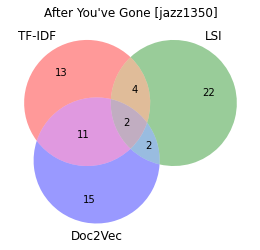

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


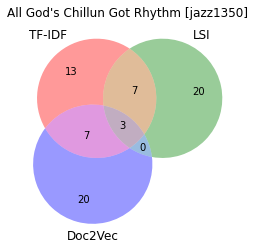

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


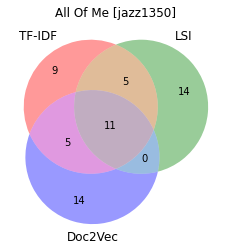

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


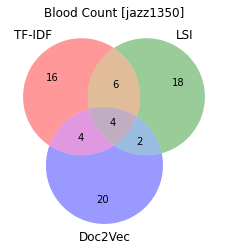

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


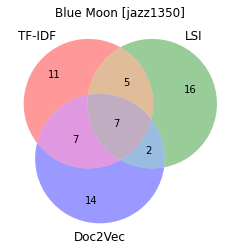

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


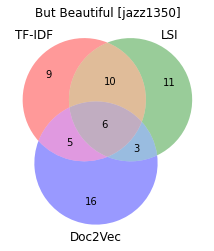

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


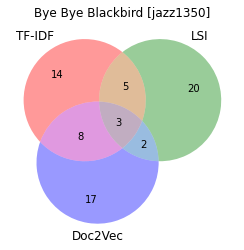

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


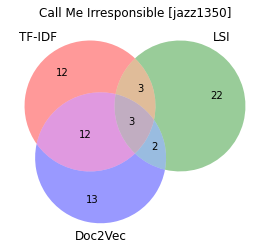

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


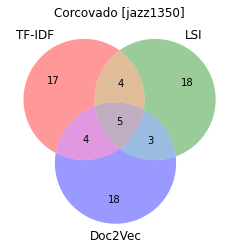

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


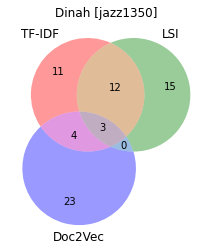

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


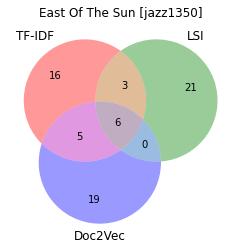

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


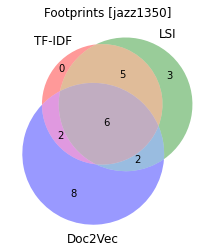

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


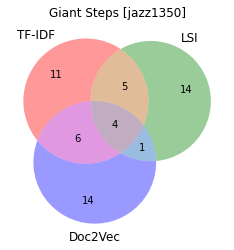

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


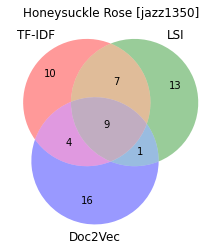

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


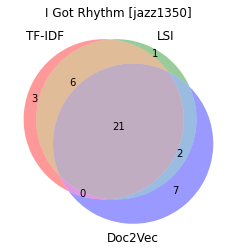

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


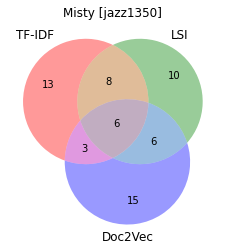

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


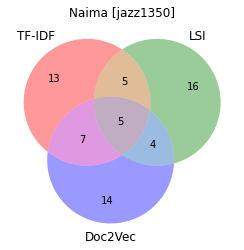

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


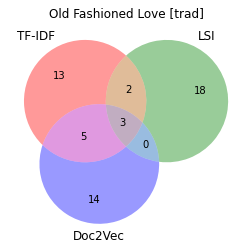

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


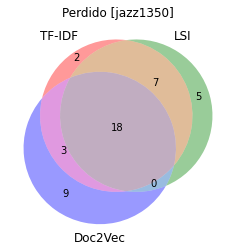

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


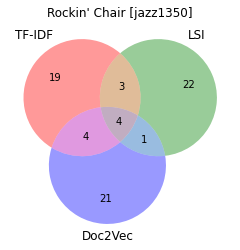

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


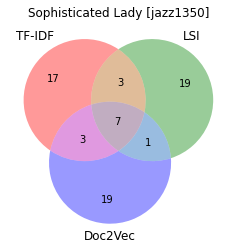

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


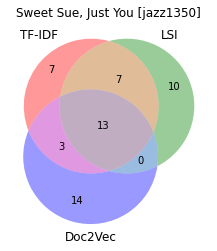

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


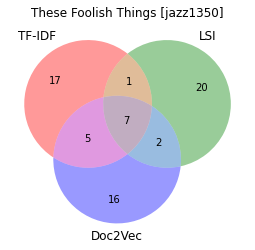

Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')
Index(['similar_title', 'score', 'max', 'score_div_max', 'reference',
       'reference_titleid'],
      dtype='object')


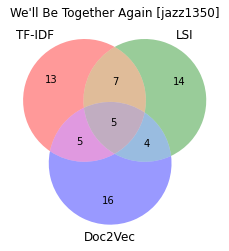

In [107]:
for tune in tunes_eval_list:
  df, details = recommend_tune(df_tfidf, tune)
  tfidf_tunes = list(df.head(30).loc[:,'similar_title'])

  df, details = recommend_tune(df_lsi, tune)
  lsi_tunes = list(df.head(30).loc[:,'similar_title'])

  df, details = recommend_tune(df_doc2vec, tune)
  word2vec_tunes = list(df.head(30).loc[:,'similar_title'])

  set_tfidf = set(tfidf_tunes)
  set_lsi = set(lsi_tunes)
  set_word2vec = set(word2vec_tunes)

  venn3([set_tfidf, set_lsi, set_word2vec], 
        set_labels=('TF-IDF', 'LSI', 'Doc2Vec'),
        )
  plt.title(f"{tune}")
  plt.savefig('plot.png')
  
  if use_wandb:
    wandb.log({"venn_methods": wandb.Image('plot.png')})
  
  plt.show()

In [108]:
# Number of tunes tested
len(contrafacts)

42

In [109]:
# number of sections in the tunes
contrafacts_sections = [title_to_sectionid[contrafacts[cc]] for cc in contrafacts.keys()]
len([val for tune in contrafacts_sections for val in tune])


143

# W&B Logging and Finish

In [110]:
recommender_results

,reference,id,method,similar,score_div_max,score
0,We'll Be Together Again [jazz1350],0.0,tfidf,You Stepped Out Of A Dream [jazz1350],1.000000,0.789605
1,We'll Be Together Again [jazz1350],1.0,tfidf,Goodbye [jazz1350],1.000000,0.856327
2,We'll Be Together Again [jazz1350],2.0,tfidf,Lazy Bird [jazz1350],1.000000,0.729080
3,We'll Be Together Again [jazz1350],3.0,tfidf,Tones For Joan's Bones [jazz1350],0.965223,0.756416
4,We'll Be Together Again [jazz1350],4.0,tfidf,It's A Raggy Waltz [jazz1350],0.947116,0.690523
...,...,...,...,...,...,...
83,We'll Be Together Again [jazz1350],NaN,doc2vec,NaN,NaN,NaN
84,We'll Be Together Again [jazz1350],NaN,doc2vec,NaN,NaN,NaN
85,We'll Be Together Again [jazz1350],NaN,doc2vec,NaN,NaN,NaN
86,We'll Be Together Again [jazz1350],NaN,doc2vec,NaN,NaN,NaN


In [111]:
recommender_results = recommender_results.reset_index()

results = recommender_results.pivot(index=['index', 'reference', 'similar'], columns='method', values=['id', 'score', 'score_div_max'])
results.columns = ['_'.join(col) for col in results.columns]
results = results.reset_index()
results

,index,reference,similar,id_doc2vec,id_lsi,id_tfidf,score_doc2vec,score_lsi,score_tfidf,score_div_max_doc2vec,score_div_max_lsi,score_div_max_tfidf
0,0,We'll Be Together Again [jazz1350],Goodbye [jazz1350],0.0,0.0,NaN,0.882073,0.922972,NaN,1.0,1.0,NaN
1,0,We'll Be Together Again [jazz1350],You Stepped Out Of A Dream [jazz1350],NaN,NaN,0.0,NaN,NaN,0.789605,NaN,NaN,1.0
2,1,We'll Be Together Again [jazz1350],Goodbye [jazz1350],NaN,NaN,1.0,NaN,NaN,0.856327,NaN,NaN,1.0
3,1,We'll Be Together Again [jazz1350],Up With The Lark [jazz1350],1.0,NaN,NaN,0.760908,NaN,NaN,1.0,NaN,NaN
4,1,We'll Be Together Again [jazz1350],What's New [jazz1350],NaN,1.0,NaN,NaN,0.841625,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
209,83,We'll Be Together Again [jazz1350],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,84,We'll Be Together Again [jazz1350],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,85,We'll Be Together Again [jazz1350],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,86,We'll Be Together Again [jazz1350],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
if use_wandb:
  table = wandb.Table(dataframe=results)
  wandb.log({"recommender results": results})

In [113]:
if use_wandb:
  wandb.finish()